<a href="https://colab.research.google.com/github/schmuecker/transfer-learning/blob/main/computer_vision/classification_from_scratch/cnn_human_action2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is HAR ?
- Human activity recognition, or HAR for short, is a broad field of study concerned with identifying the specific movement or action of a person based on sensor data. 
- Movements are often typical activities performed indoors, such as walking, talking, standing, and sitting

# Why it is important ?

- Human activity recognition plays a significant role in human-to-human interaction and interpersonal relations. 
- Because it provides information about the identity of a person, their personality, and psychological state, it is difficult to extract. 
- The human ability to recognize another person’s activities is one of the main subjects of study of the scientific areas of computer vision and machine learning. As a result of this research, many applications, including video surveillance systems, human-computer interaction, and robotics for human behavior characterization, require a multiple activity recognition system.

#  Here are some example:

![](https://user-images.githubusercontent.com/11255376/71256359-d6ca1300-2373-11ea-812a-babb3b5b2ad5.gif)

![](https://learnopencv.com/wp-content/uploads/2021/07/yoga-poses.gif)

# HAR using CNN

### Import libraries

In [ ]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
from datasets import load_dataset
from PIL import Image
from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

## Enable GPU

Make sure "GPU" is selected under Edit -> Notebook Settings -> Hardware Acceleration

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Downloading the dataset

In [ ]:
dataset = load_dataset("Bingsu/Human_Action_Recognition")
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 5400
    })
})

In [ ]:
classes = {
     0: 'calling',
     1: 'clapping',
     2: 'cycling',
     3: 'dancing',
     4: 'drinking',
     5: 'eating',
     6: 'fighting',
     7: 'hugging',
     8: 'laughing',
     9: 'listening_to_music',
     10: 'running',
     11: 'sitting',
     12: 'sleeping',
     13: 'texting',
     14: 'using_laptop',
}

# Creating a function to random take a image and display it with its label

In [ ]:
def disp():
    num = random.randint(1,10000)
    testImage = dataset['train'][num]['image']
    print(testImage)
    plt.imshow(testImage)
    plt.title(classes[dataset['train'][num]['labels']])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=179x281 at 0x7F66E0687BD0>


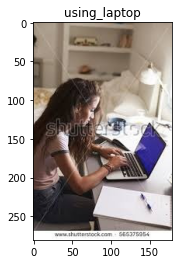

In [ ]:
disp()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=267x189 at 0x7F66E0566F90>


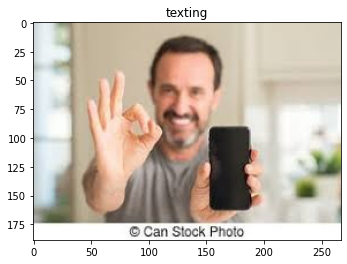

In [ ]:
disp()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x195 at 0x7F66E0032450>


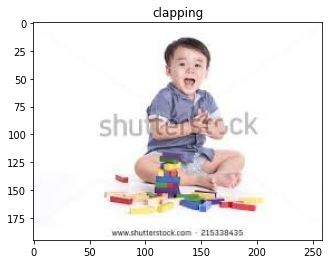

In [ ]:
disp()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=175x288 at 0x7F668C6A2ED0>


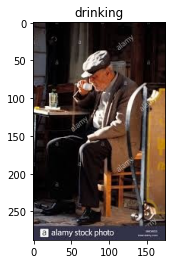

In [ ]:
disp()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=99x84 at 0x7F668C6AB890>


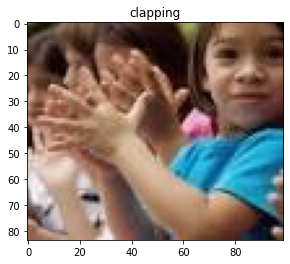

In [ ]:
disp()

# Processing data

In [ ]:
X_train, y_train = [], []

for a in dataset['train']:
  image, labels = a['image'], a['labels']
  img = np.asarray(image.resize((160,160)), dtype=np.float32)
  X_train.append(img)
  y_train.append(labels)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train.shape, y_train.shape

((12600, 160, 160, 3), (12600,))

In [ ]:
X_train.shape, y_train.shape

((12600, 160, 160, 3), (12600,))

In [ ]:
X_test = []

for a in dataset['test']:
  image = a['image']
  img = np.asarray(image.resize((160,160)), dtype=np.float32)
  X_test.append(img)

X_test = np.array(X_test)

In [ ]:
X_test.shape

(5400, 160, 160, 3)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 80 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('loss') < 0.3) and (logs.get('accuracy') > 0.8):

      # Stop if threshold is met
      print("\nLoss is lower than 0.3 and accuracy higher than 0.8. Cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
model = Sequential()

model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(160,160,3)))
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(15, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               2

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, callbacks=[callbacks])

Epoch 1/100
394/394 [==============================] - 22s 28ms/step - loss: 30.6500 - accuracy: 0.0877
Epoch 2/100
394/394 [==============================] - 11s 27ms/step - loss: 2.5417 - accuracy: 0.1692
Epoch 3/100
394/394 [==============================] - 10s 26ms/step - loss: 2.0801 - accuracy: 0.3337
Epoch 4/100
394/394 [==============================] - 10s 27ms/step - loss: 1.5377 - accuracy: 0.5148
Epoch 5/100
394/394 [==============================] - 10s 26ms/step - loss: 1.0802 - accuracy: 0.6637
Epoch 6/100
394/394 [==============================] - 10s 26ms/step - loss: 0.7845 - accuracy: 0.7579
Epoch 7/100
394/394 [==============================] - 11s 27ms/step - loss: 0.5977 - accuracy: 0.8258
Epoch 8/100
394/394 [==============================] - 10s 27ms/step - loss: 0.5271 - accuracy: 0.8463
Epoch 9/100
394/394 [==============================] - 10s 27ms/step - loss: 0.4287 - accuracy: 0.8732
Epoch 10/100
394/394 [==============================] - 10s 27ms/step - 

In [ ]:
model.save_weights("model.h5")

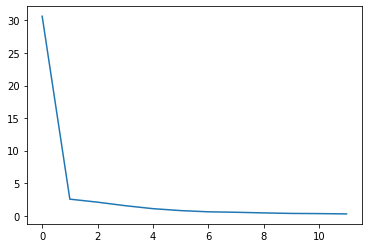

In [ ]:
loss = history.history['loss']
plt.plot(loss)

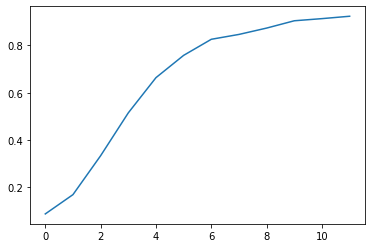

In [ ]:
accu = history.history['accuracy']
plt.plot(accu)

# Custom Testing

In [ ]:
# Function to predict

def test_predict():
    test_index = random.randint(1,len(X_test))
    result = model.predict(X_test[test_index].reshape(1,160,160,3))
    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = dataset['test'][test_index]['image']
    plt.imshow(image)
    plt.title(classes[prediction])

1/1 [==============================] - 0s 325ms/step
probability: 99.99890327453613%
Predicted class :  4


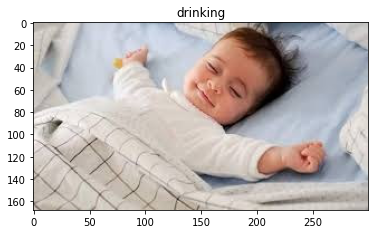

In [ ]:
test_predict()

1/1 [==============================] - 0s 18ms/step
probability: 100.0%
Predicted class :  1


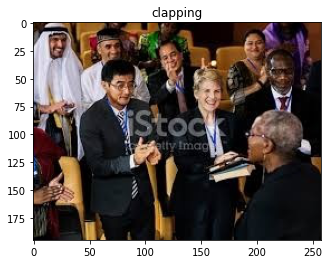

In [ ]:
test_predict()

1/1 [==============================] - 0s 16ms/step
probability: 95.74782848358154%
Predicted class :  2


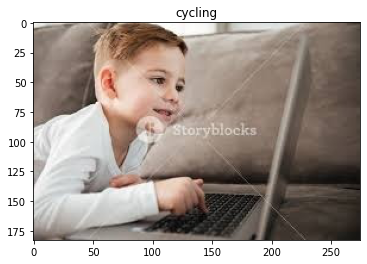

In [ ]:
test_predict()

1/1 [==============================] - 0s 17ms/step
probability: 99.51829314231873%
Predicted class :  7


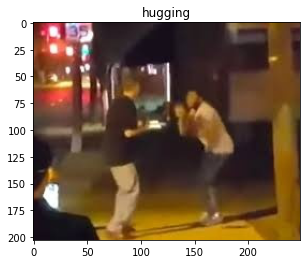

In [ ]:
test_predict()

1/1 [==============================] - 0s 18ms/step
probability: 97.74438738822937%
Predicted class :  10


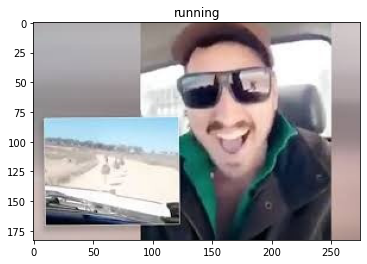

In [ ]:
test_predict()